# Sam Jackson, MAE 494, Project 1

This Python code provides answers to the problem posed in Project 1. The packages used in this project are numerous, and are listed below. The packages used are the same as the sample code for the project given in the Project 1 notebook.

In [1]:
# Setup

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

## Documentation of Problem Formulation

For my spin on the simple rocket landing problem proposed, I decided to enhance the problem by defining the action and state spaces more realistically. I did this by formulating the problem as a 2D problem which takes into account the x, y, and rotational position of the rocket.

To do this, I had the problem use a total of 6 parameters in the state space and 2 parameters in the action space. The parameters used in the state space were the x, y, and rotational orientation of the rocket and their velocities. The parameters used in the action space were a parameter controlling the linear thrust that the rocket could produce, and a parameter controlling the rotational thrust applied to turn the rocket. In this problem formulation, it was assumed that the rocket could only produce  linear thrust parallel to the rocket, thus requiring the rocket to rotate to adjust its trajectory. These state and action parameters with their units and orientations(if applicable) are listed out below:

        action[0] = linear_thrust     (m/s^2)
        action[1] = rotational_thrust (rads/s^2)
        
        state[0] = x                  (m)        [0 at origin, +dir is right]
        state[1] = x_dot              (m/s)
        state[2] = y                  (m)        [0 at origin, +dir is up]
        state[3] = y_dot              (m/s)
        state[4] = rocket_orientation (rads)     [0 when rocket is straight upwards, +dir rotates ccw]
        state[5] = rotational_velocity(rads/s)

To solve this problem and create the objective function, I decided that at the ending time each of these state parameters should be as close to 0 as possible such that the rocket would land on the target spot without the possibility of slipping or tipping over after landing due to residual velocities. Translating this into the objective function, a simple mean-square function is acceptable and so the equation shown below was used:

$$\begin{aligned} &\text{minimize:} && obj(x)=\sum_{i=0}^{5}{(x_i)^2} \end{aligned}$$

The assumptions used in implementing the problem are as such:
1. Gravity is constant, even with these large distances
2. The rocket's body was simplified into a single point at the bottom of the rocket, representative of the whole body when landing.
3. The rocket rotates around this single point whenever it rotates.
4. 


In [25]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = -0.0981 # gravity constant (m/s^2)
BOOST_ACCEL = 0.18 # thrust constant (m/s^2)
ROTATION_ACCEL = 120*math.pi/180  # rotation constant (radians)


In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0] = linear_thrust     (m/s^2)
        action[1] = rotational_thrust (rads/s^2)
        
        state[0] = x                  (m)     [0 at origin, +dir is right]
        state[1] = x_dot              (m/s)
        state[2] = y                  (m)     [0 at origin, +dir is up]
        state[3] = y_dot              (m/s)
        state[4] = rocket_orientation (rads)  [0 when rocket is straight upwards, +dir is ccw]
        state[5] = rotational_velocity(rads/s)
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[4] = x[4] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[4]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., 0., 0., gravity * delta_time, 0., 0.], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Linear Thrust
        # Note: Same reason as above. Need a 6-by-1 tensor.
        delta_state_thrust = BOOST_ACCEL * FRAME_TIME * t.tensor([0., t.sin(state[4]), 0., t.cos(state[4]), 0., 0.]) * action[0]
        
        # Rotational Thrust
        # Note: Same reason as above. Need a 6-by-1 tensor.
        delta_state_rotation = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * action[1]

        # Update velocity
        state = state + delta_state_thrust + delta_state_rotation + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., FRAME_TIME, 0., 0.],
                            [0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Sigmoid(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Tanh()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, input_state):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(input_state)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(input_state):
        state = np.array(input_state)
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        loss = t.sum(t.square(state))
        return loss

In [35]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. Visualize shows the variation of each of the state variable and action variable with time
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.Adam(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        # Establishing data arrays to plot
        statedata = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actiondata = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        Time = FRAME_TIME * np.linspace(0,T,T)
        x = statedata[:, 0]
        xdot = statedata[:, 1]
        y = statedata[:, 2]
        ydot = statedata[:, 3]
        rot = statedata[:, 4]
        rotdot = statedata[:, 5]
        thrust = actiondata[:, 0]
        rotthrust = actiondata[:,1]
        
        # Creating the plot for each of the state variables
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Time, y, label = 'y position')
        ax1.plot(Time, ydot, label = 'ydot')
        ax1.plot(Time, x, label = 'x position')
        ax1.plot(Time, xdot, label = 'xdot')
        ax1.plot(Time, rot, label = 'rot')
        ax1.plot(Time, rotdot, label = 'rotdot')
        plt.xlabel('Time, s')
        plt.ylabel('State Variables')
        plt.title('State Variables vs. Time')
        plt.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        # Creating the plot for each of the action variables
        f2 = plt.figure()
        ax2 = f2.add_subplot(111)
        ax2.plot(Time, thrust, label = 'thrust')
        ax2.plot(Time, rotthrust, label = 'rotthrust')
        plt.xlabel('Time, s')
        plt.ylabel('Action Variables')
        plt.title('Action Variables vs. Time')
        plt.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.show()

[1] loss: 447.104


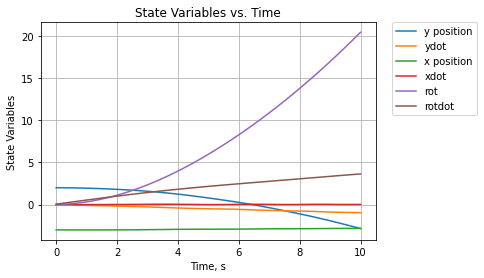

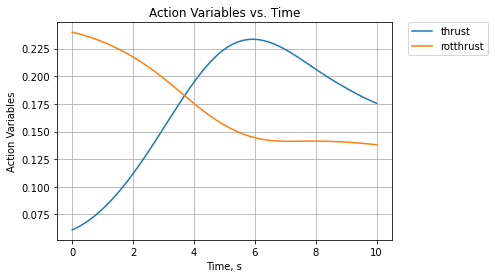

[2] loss: 53.752


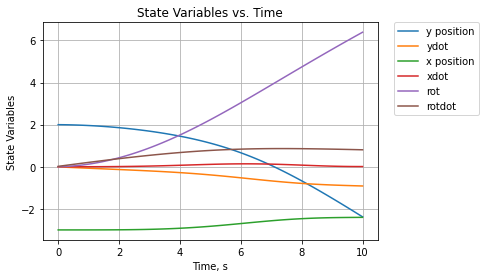

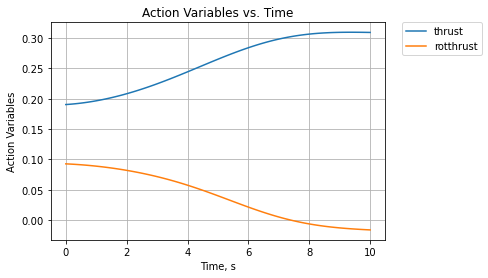

[3] loss: 23.349


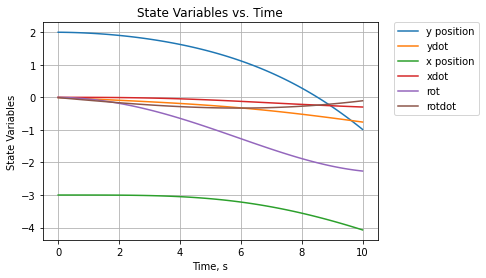

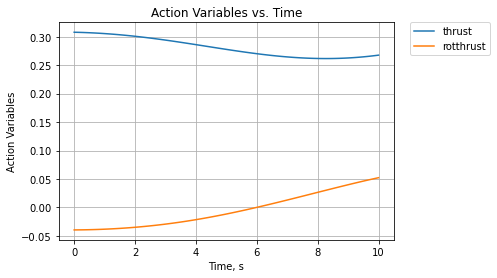

[4] loss: 110.826


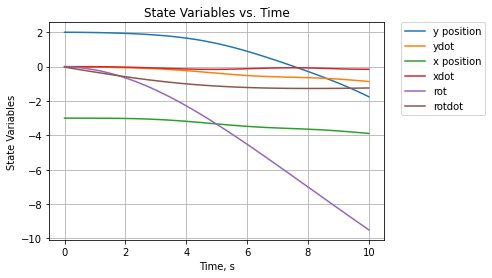

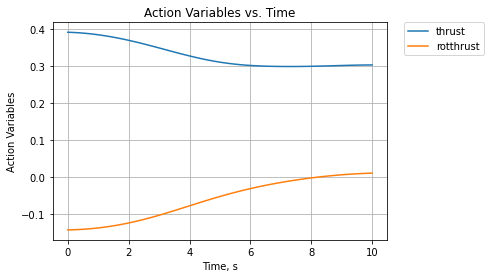

[5] loss: 183.844


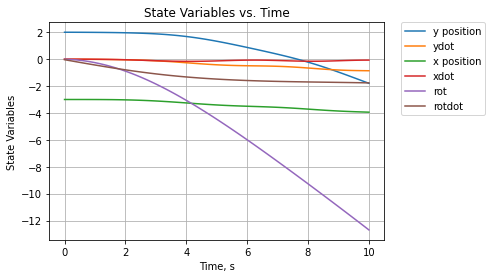

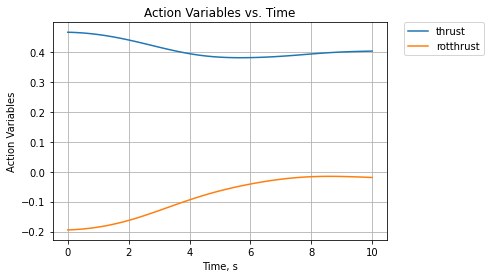

[6] loss: 159.485


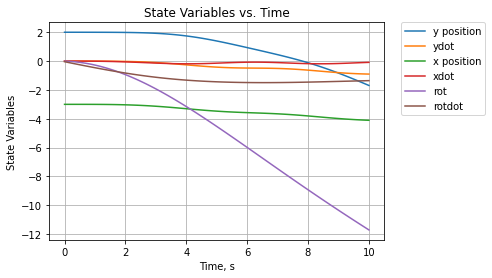

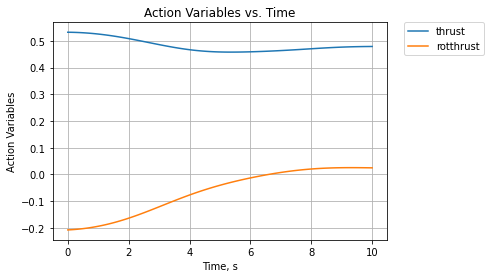

[7] loss: 101.211


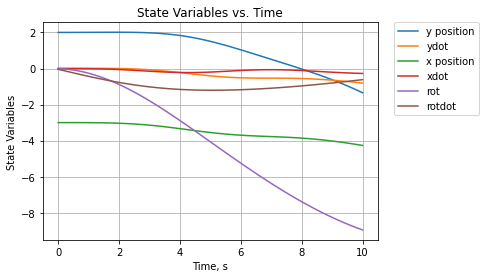

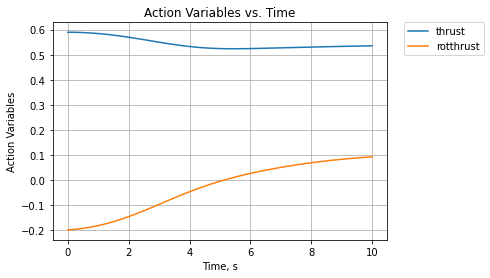

[8] loss: 56.910


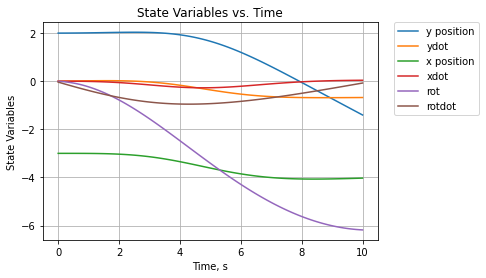

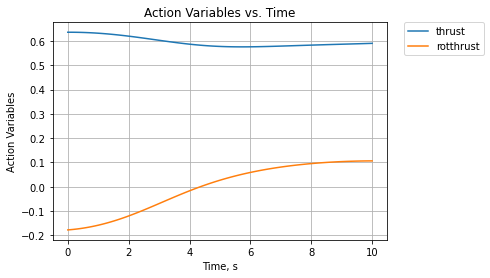

[9] loss: 43.704


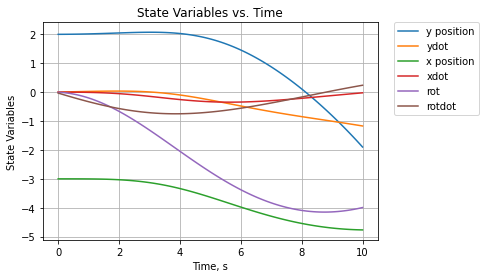

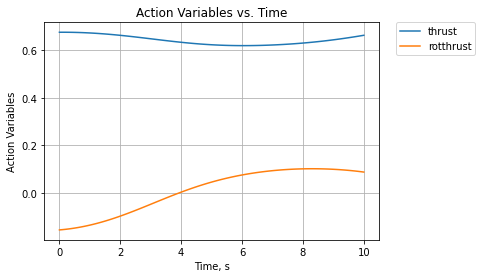

[10] loss: 46.151


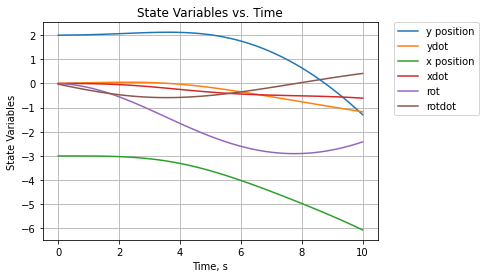

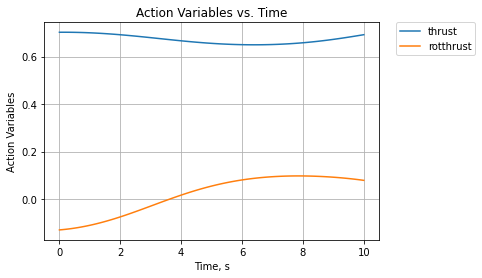

[11] loss: 47.630


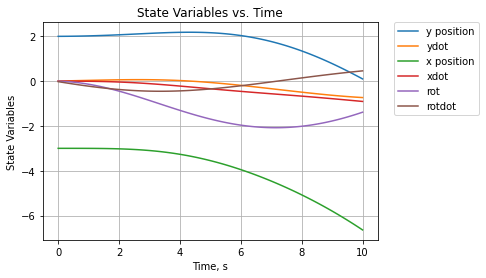

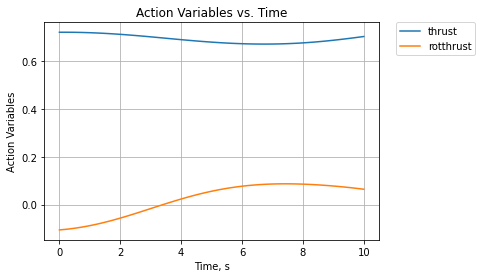

[12] loss: 45.162


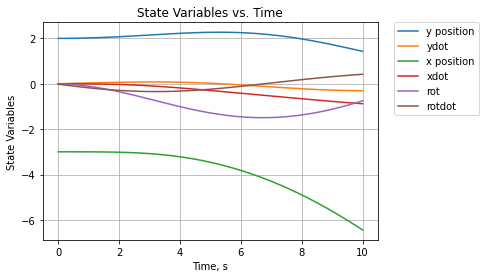

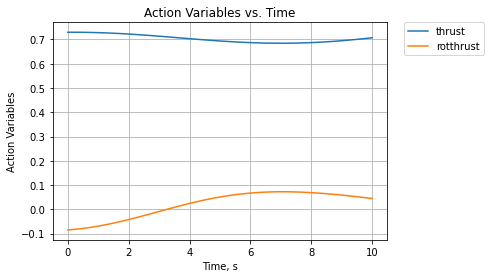

[13] loss: 40.408


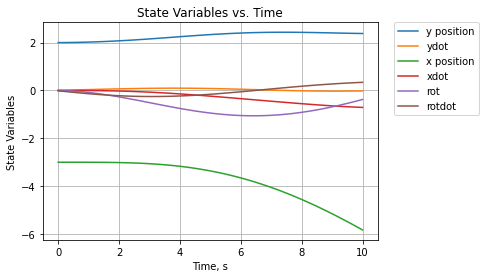

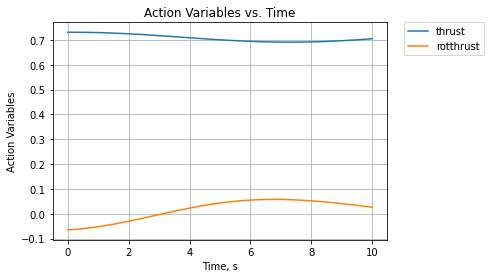

[14] loss: 34.940


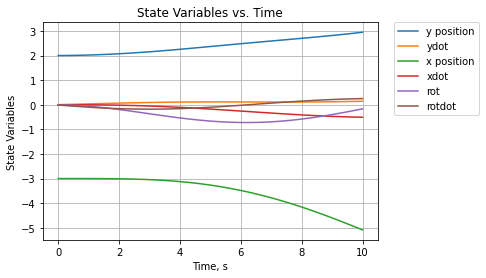

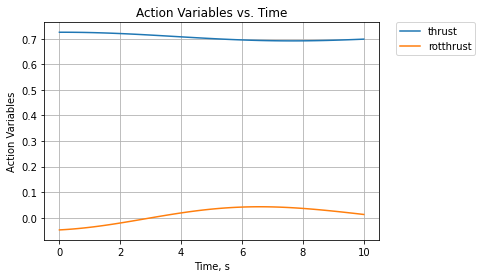

[15] loss: 29.589


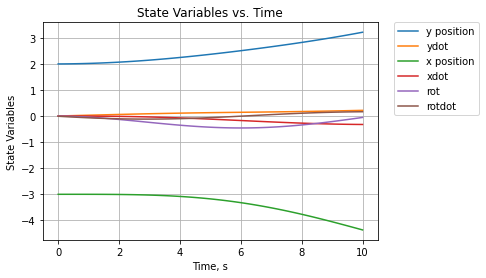

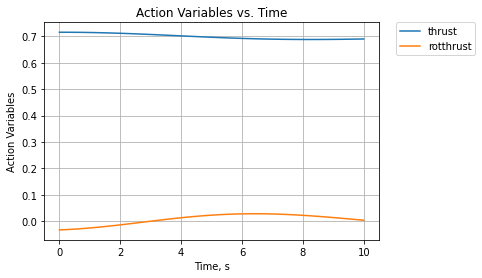

[16] loss: 24.692


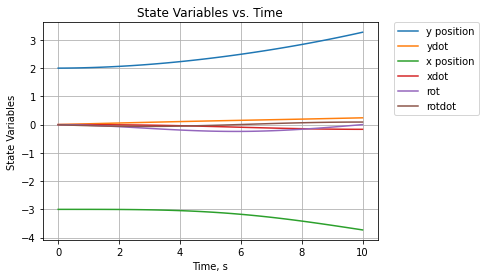

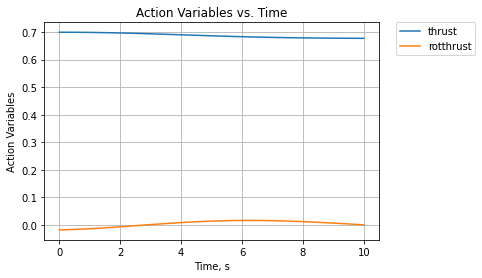

[17] loss: 20.345


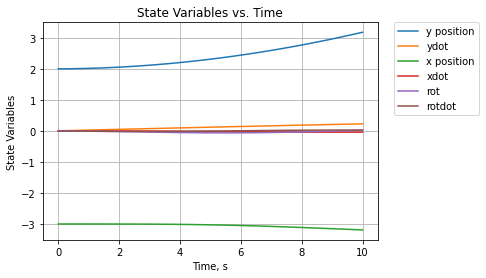

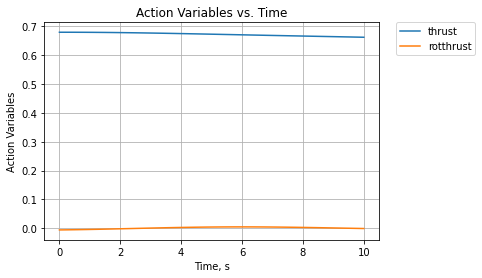

[18] loss: 16.548


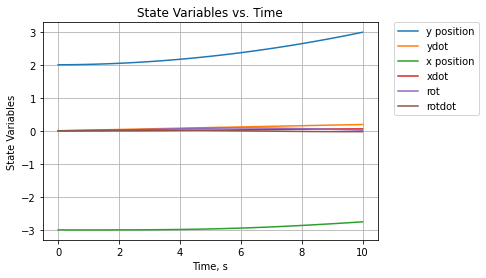

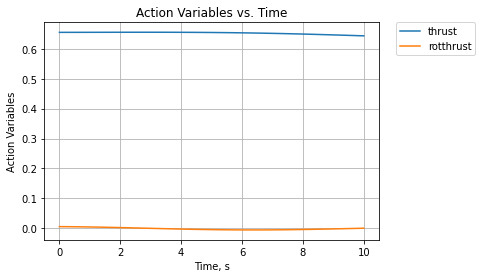

[19] loss: 13.270


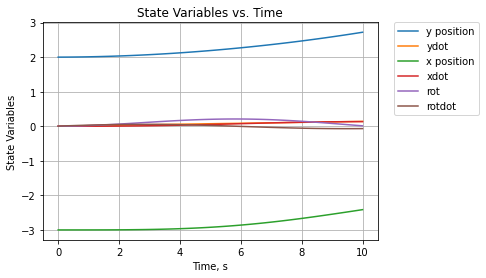

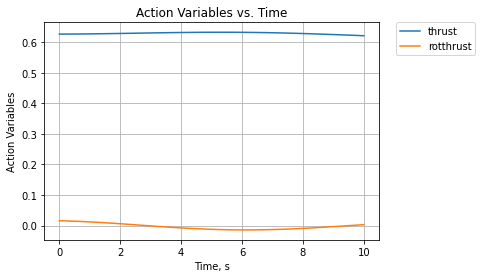

[20] loss: 10.484


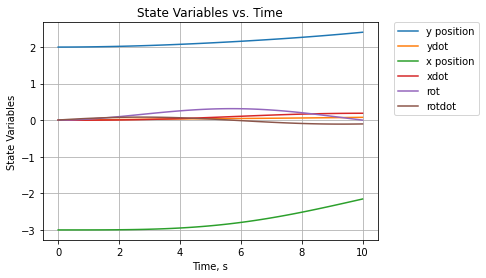

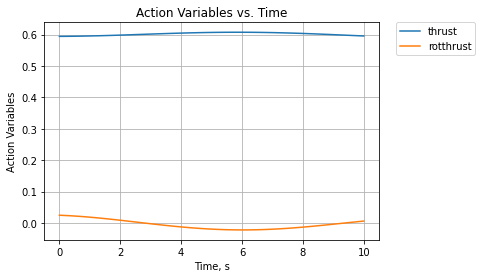

[21] loss: 8.172


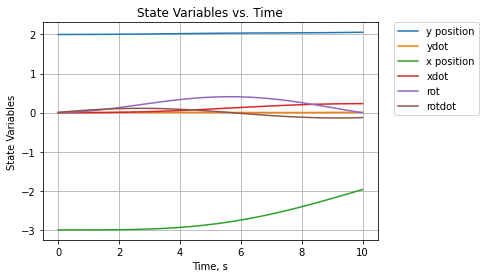

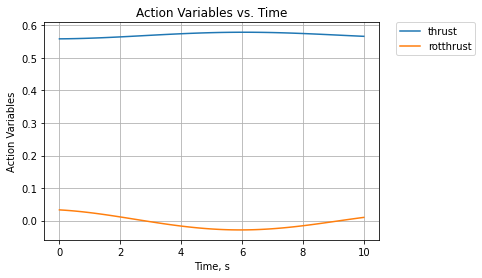

[22] loss: 6.329


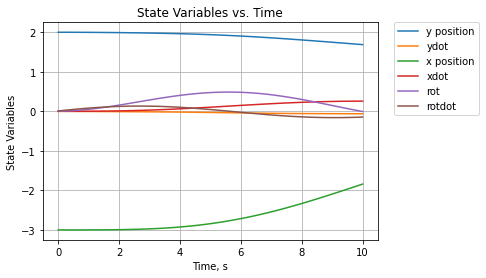

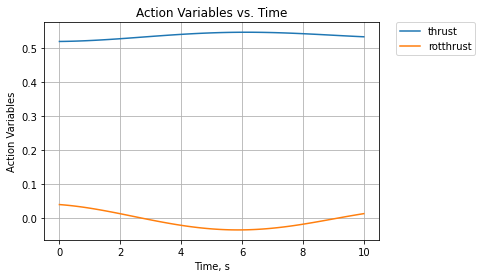

[23] loss: 4.949


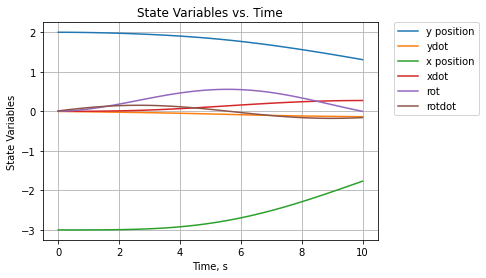

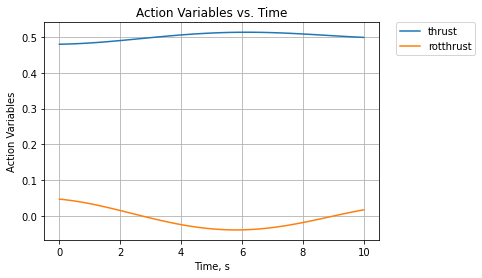

[24] loss: 4.021


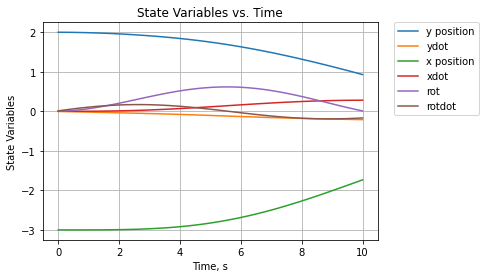

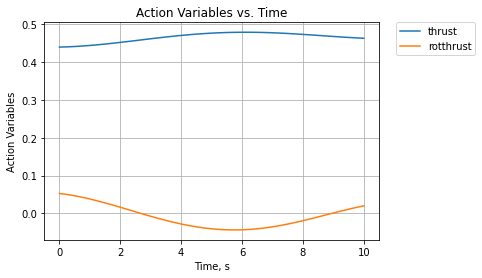

[25] loss: 3.507


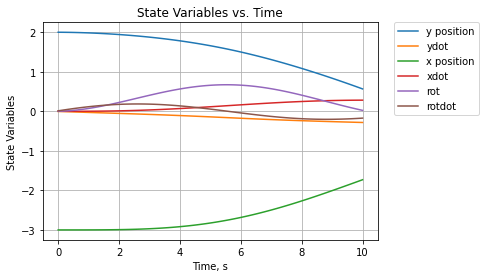

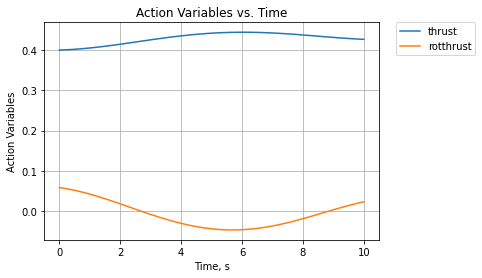

[26] loss: 3.343


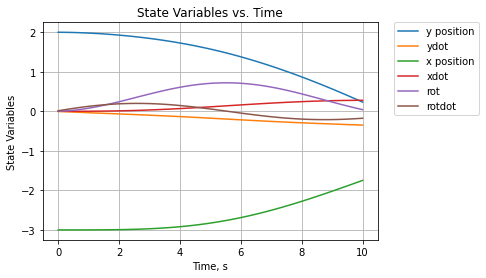

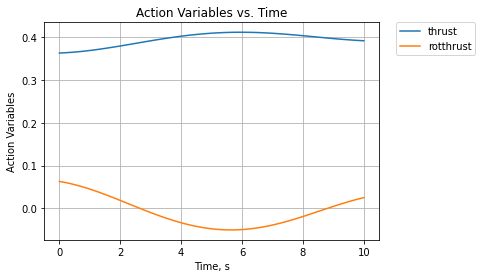

[27] loss: 3.429


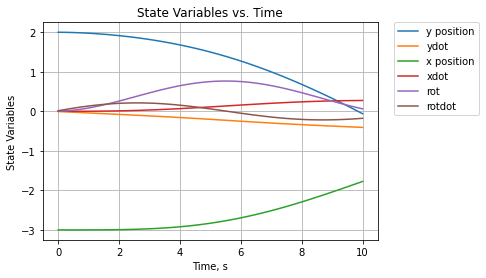

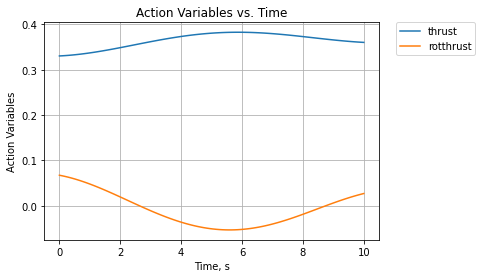

[28] loss: 3.647


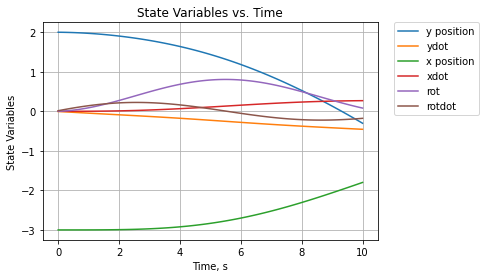

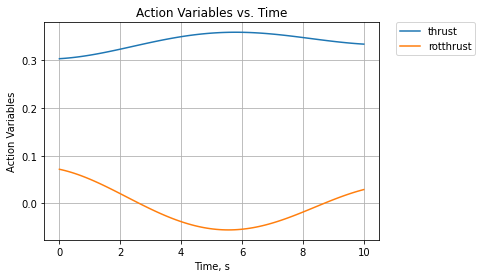

[29] loss: 3.876


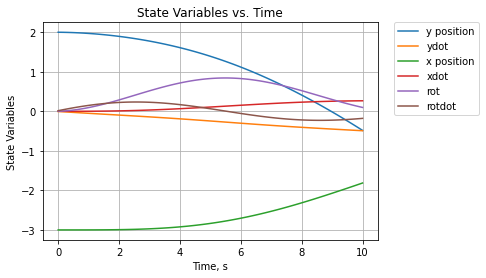

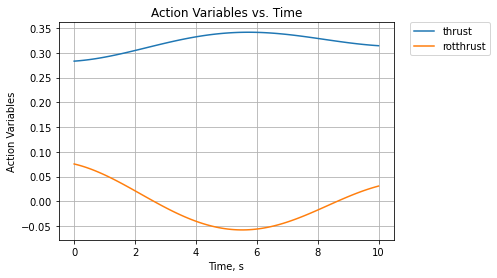

[30] loss: 4.016


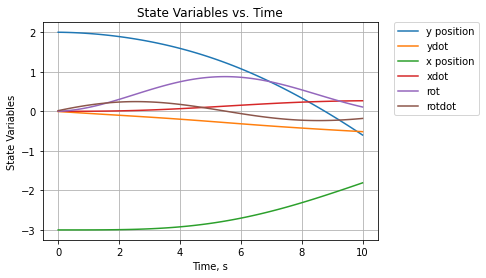

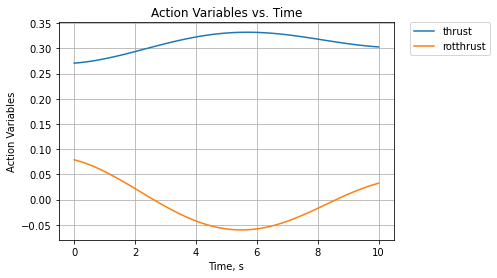

[31] loss: 4.008


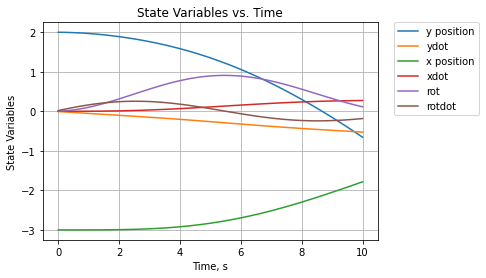

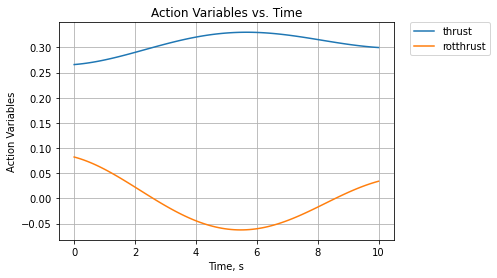

[32] loss: 3.833


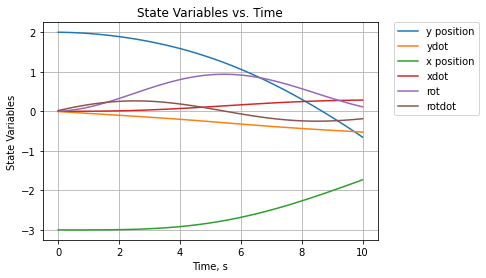

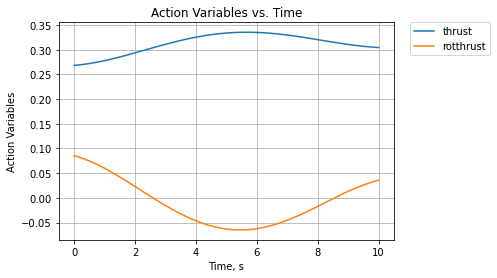

[33] loss: 3.515


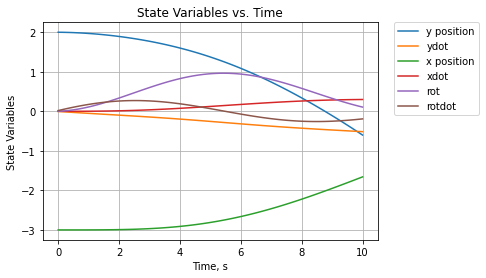

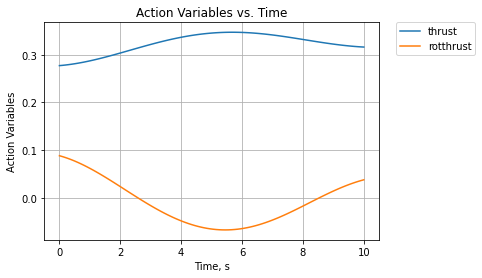

[34] loss: 3.102


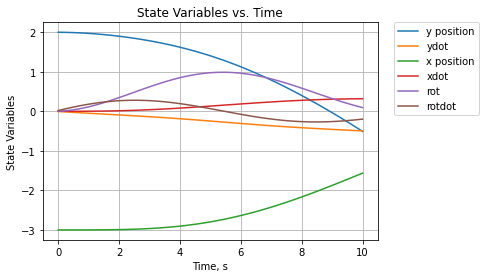

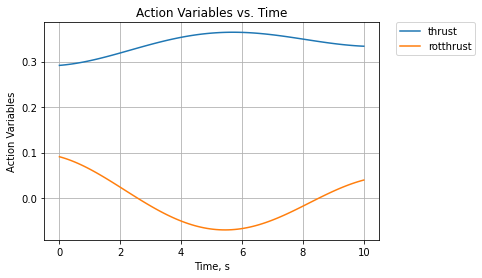

[35] loss: 2.651


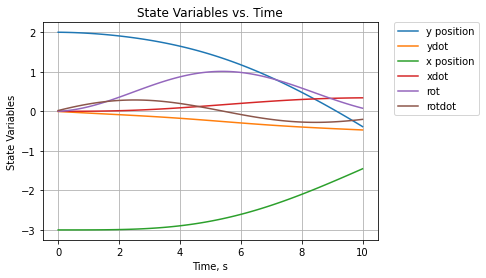

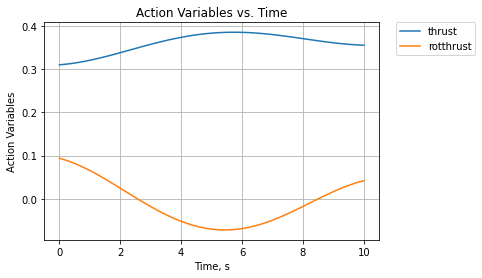

[36] loss: 2.215


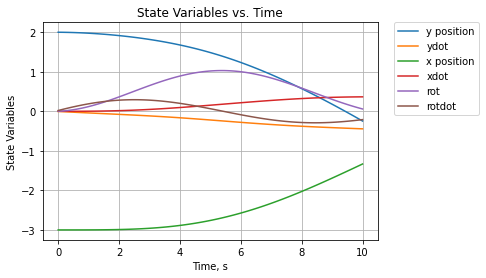

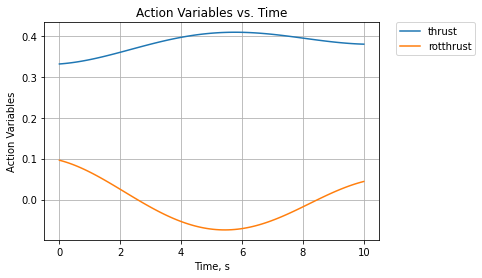

[37] loss: 1.835


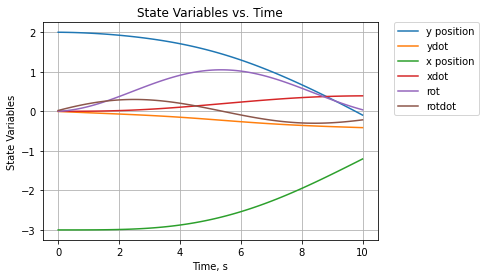

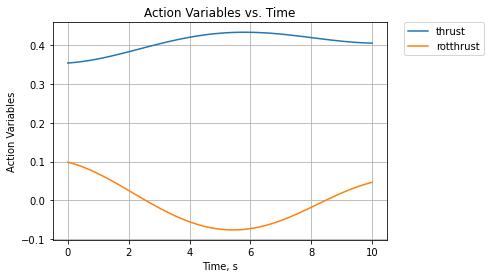

[38] loss: 1.535


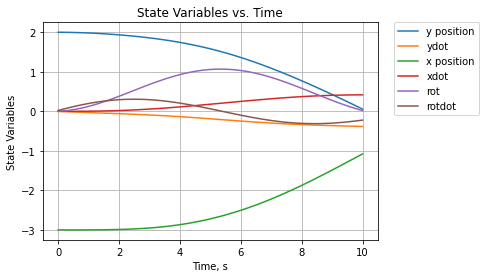

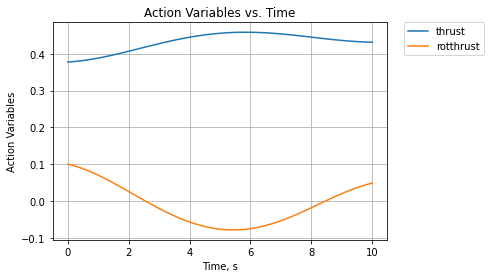

[39] loss: 1.320


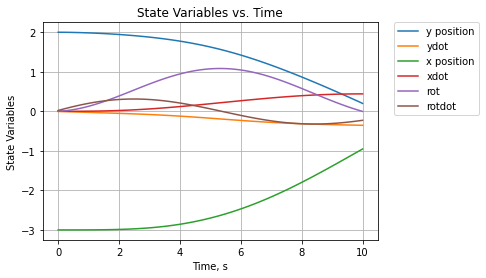

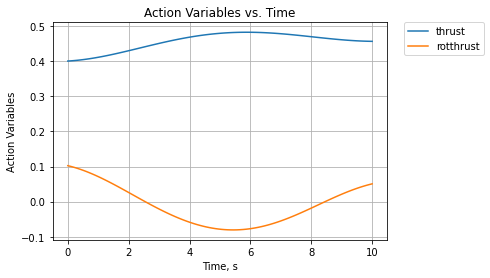

[40] loss: 1.187


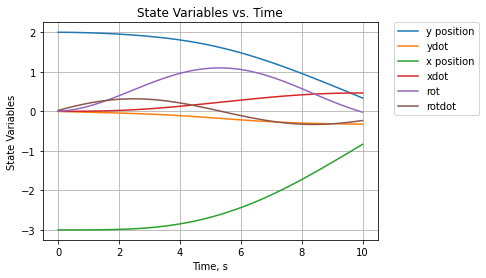

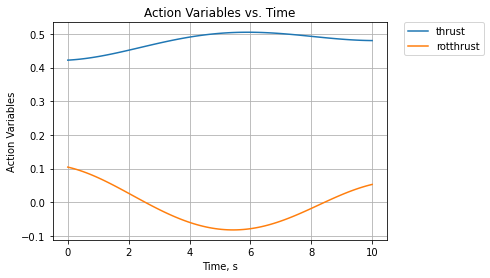

[41] loss: 1.120


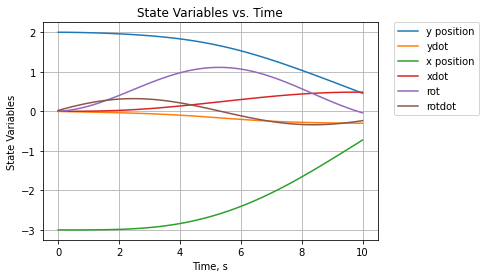

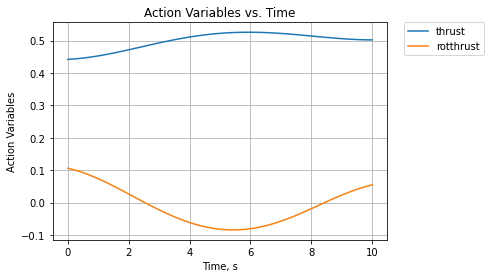

[42] loss: 1.104


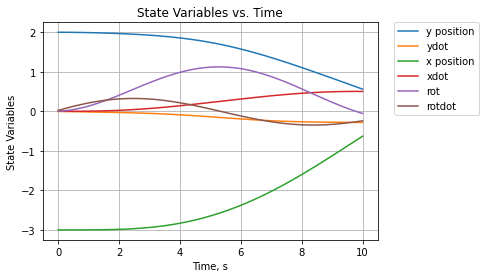

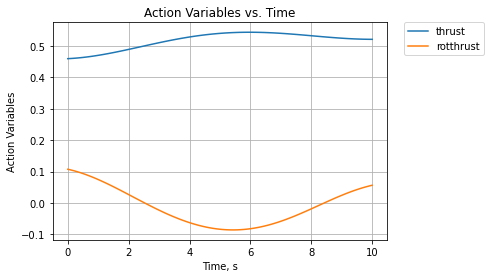

[43] loss: 1.119


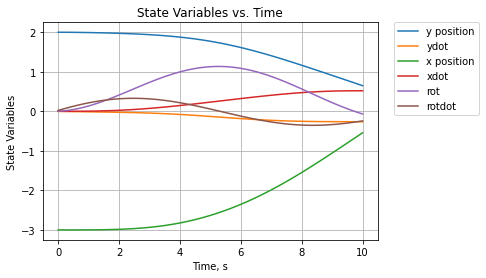

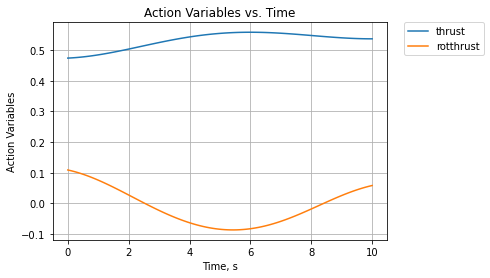

[44] loss: 1.151


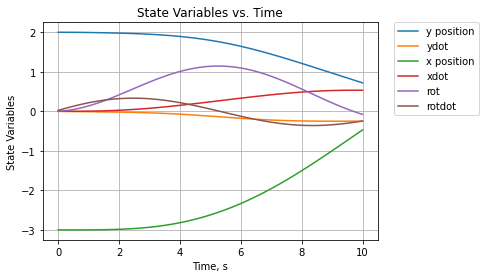

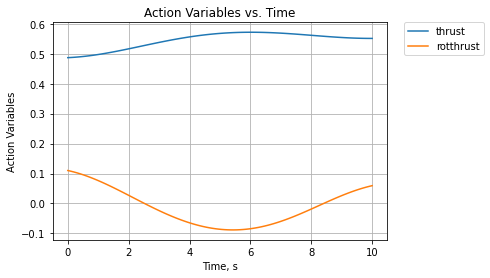

[45] loss: 1.187


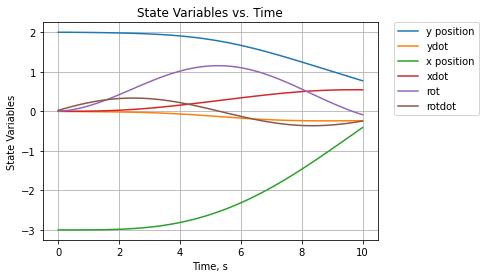

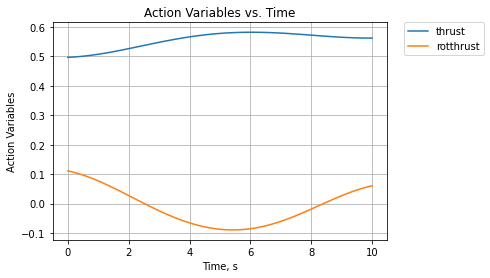

[46] loss: 1.217


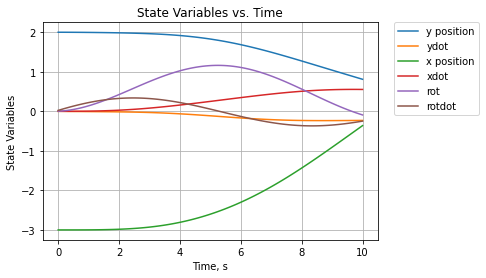

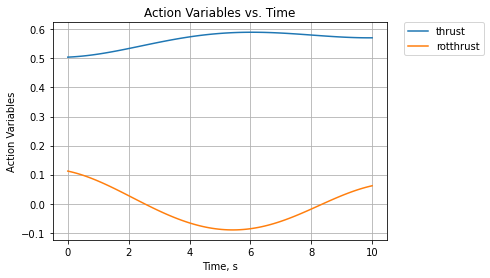

[47] loss: 1.235


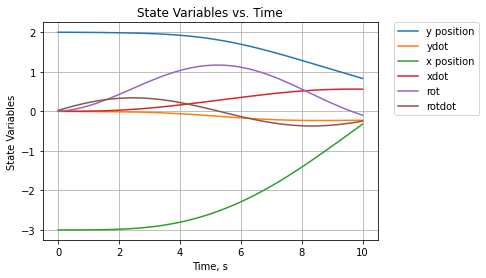

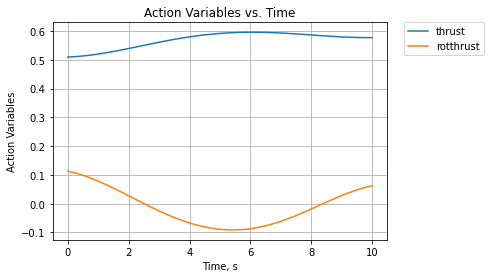

[48] loss: 1.239


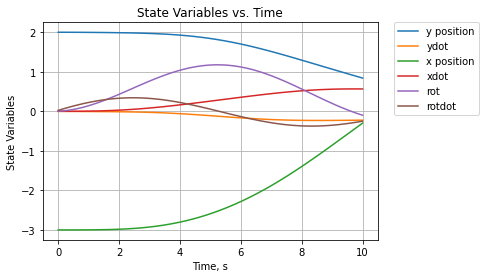

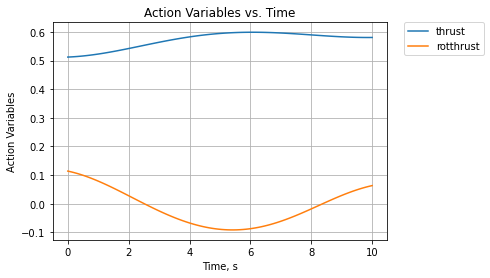

[49] loss: 1.226


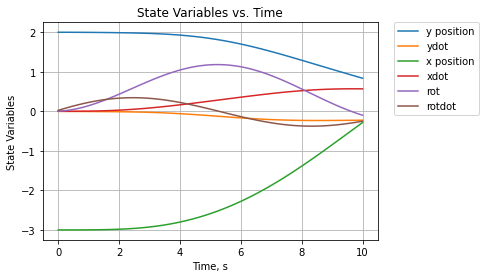

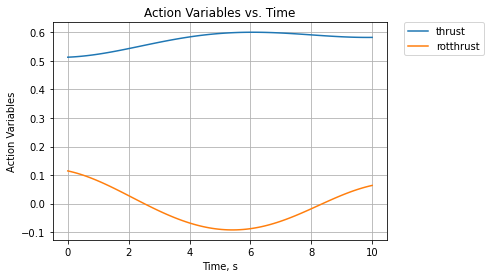

[50] loss: 1.199


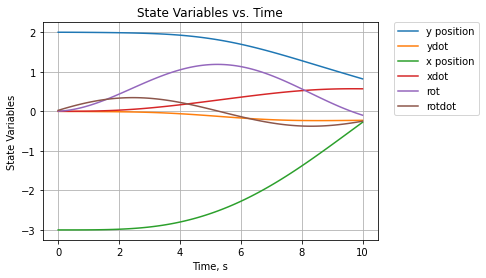

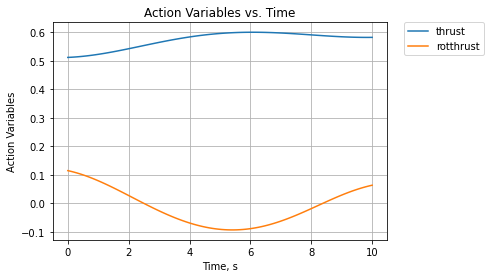

[51] loss: 1.159


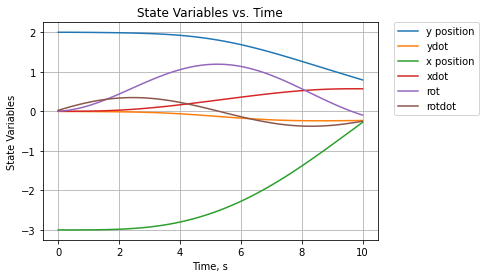

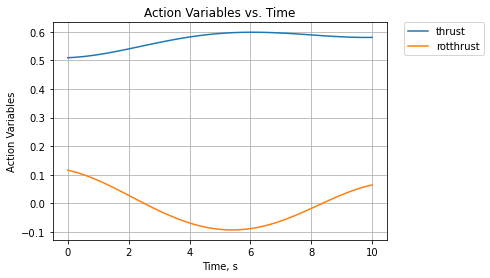

[52] loss: 1.110


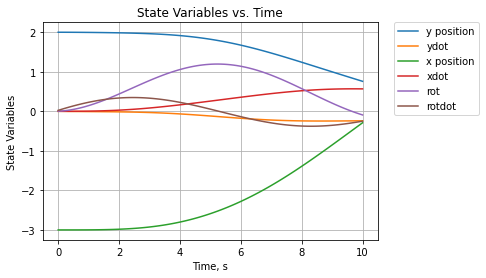

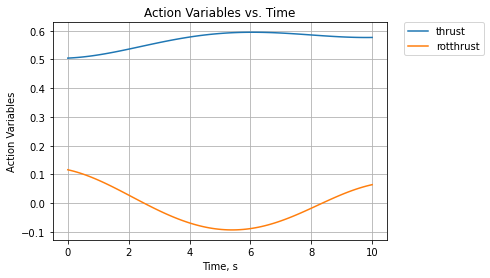

[53] loss: 1.056


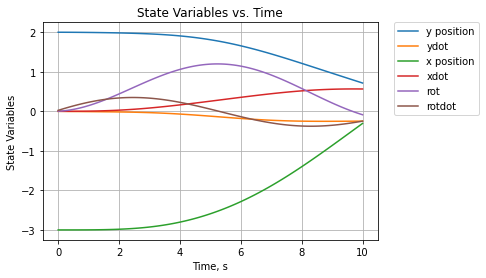

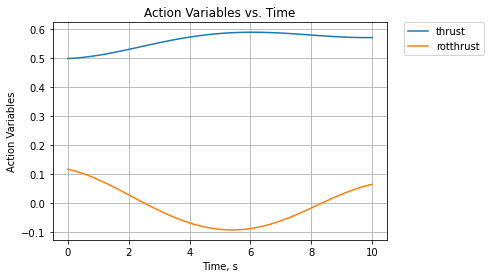

[54] loss: 1.001


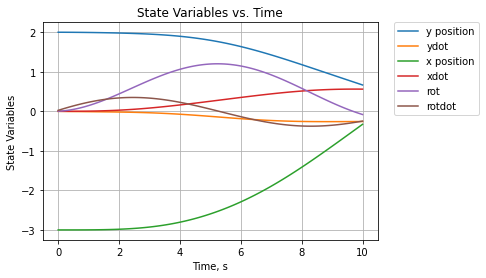

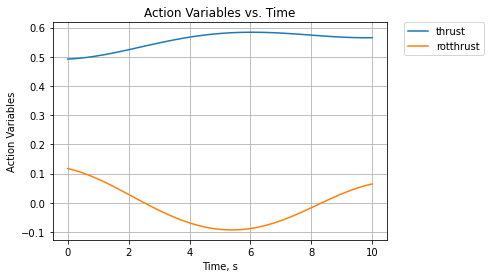

[55] loss: 0.949


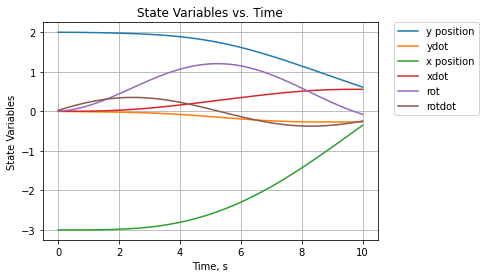

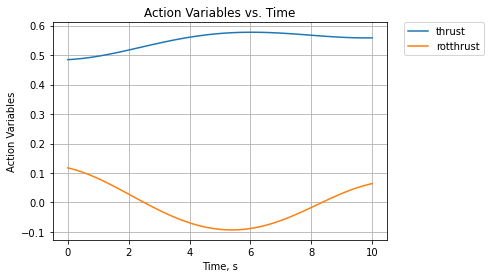

[56] loss: 0.903


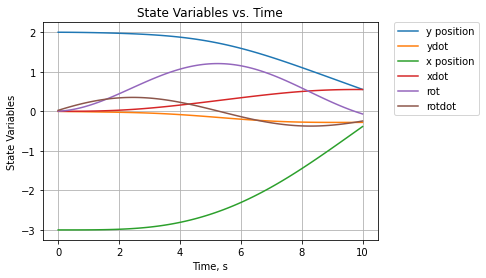

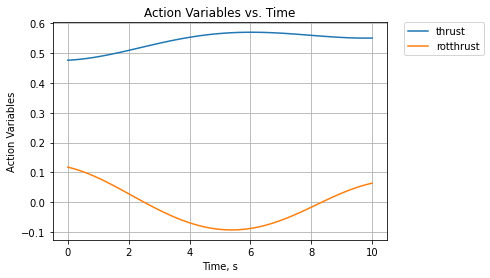

[57] loss: 0.865


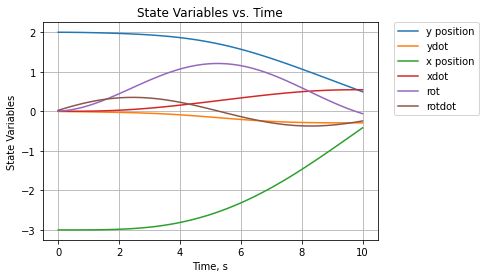

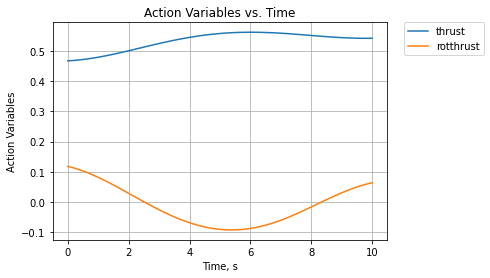

[58] loss: 0.838


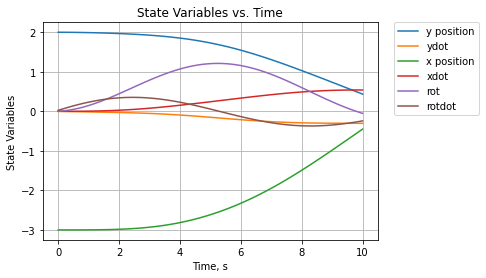

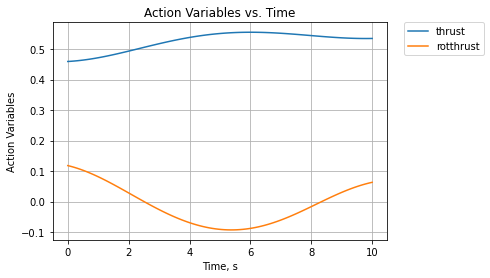

[59] loss: 0.821


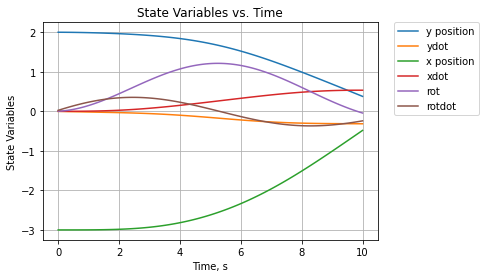

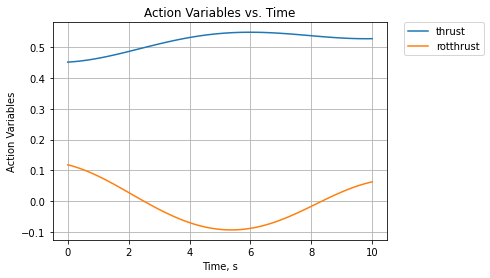

[60] loss: 0.813


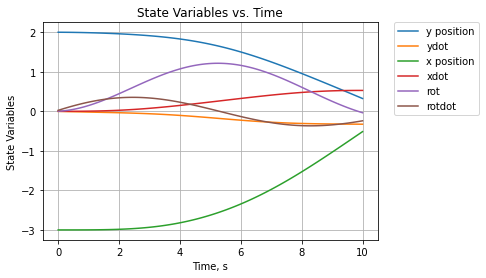

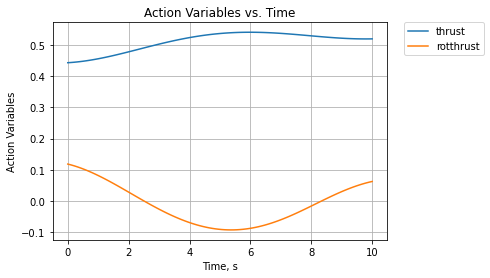

[61] loss: 0.814


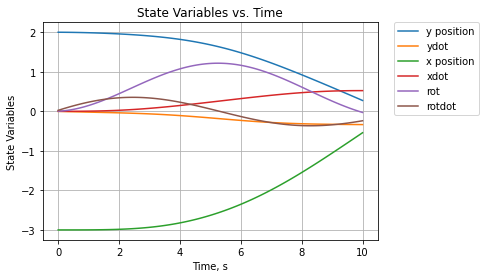

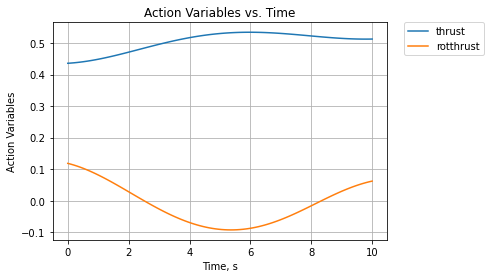

[62] loss: 0.819


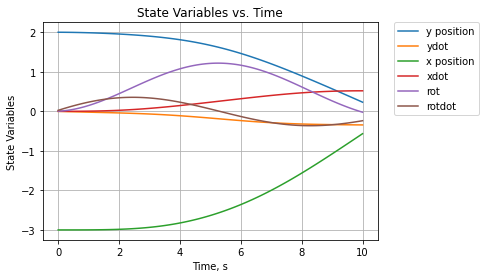

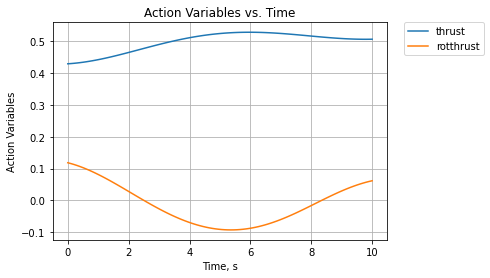

[63] loss: 0.827


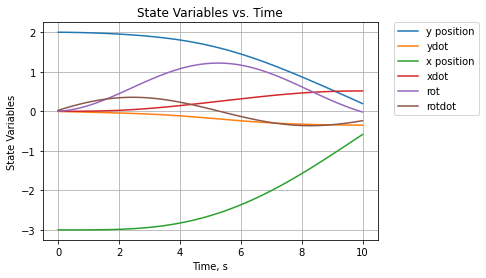

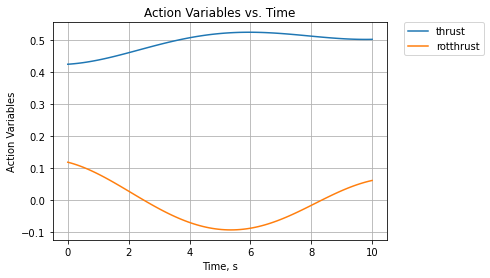

[64] loss: 0.835


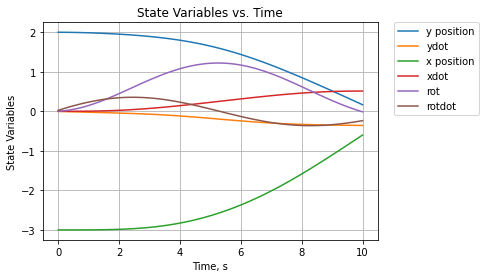

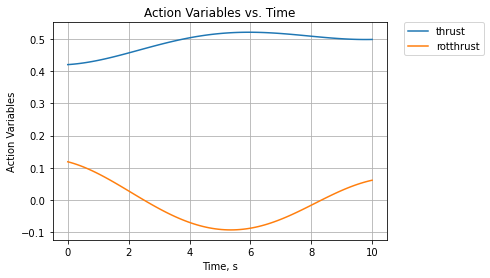

[65] loss: 0.841


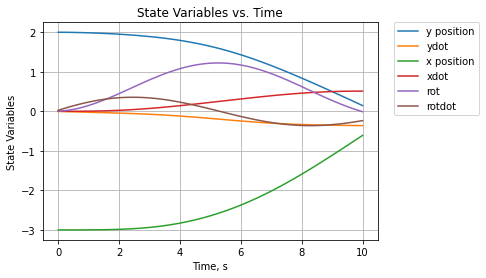

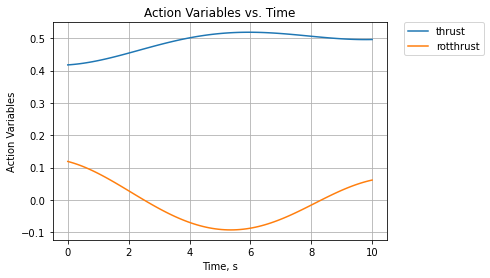

[66] loss: 0.843


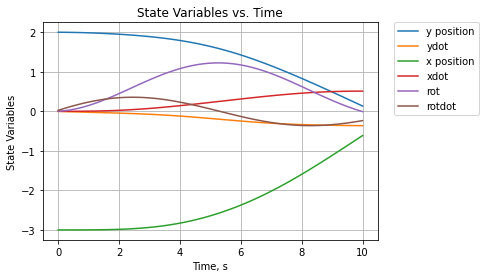

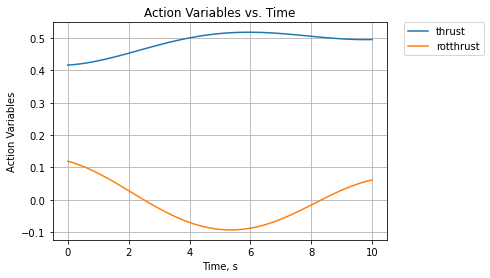

[67] loss: 0.841


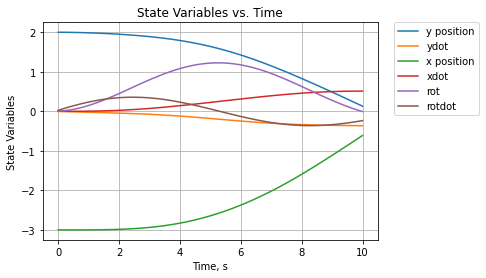

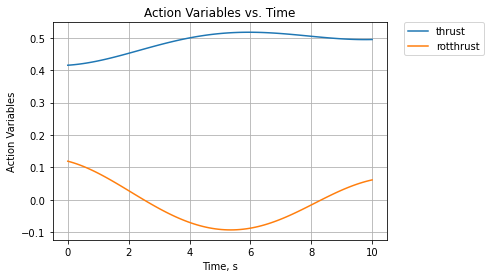

[68] loss: 0.834


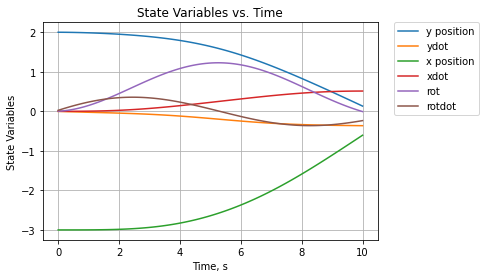

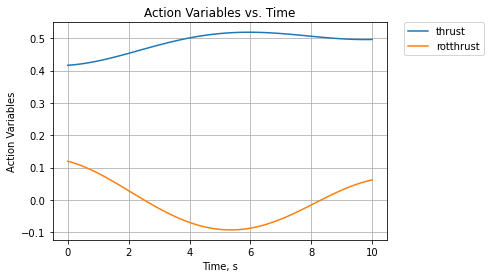

[69] loss: 0.825


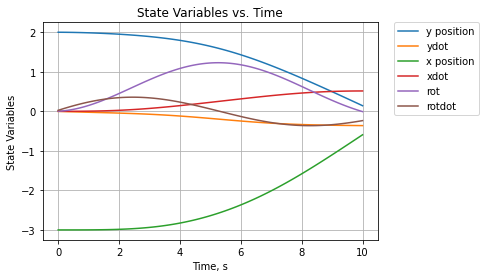

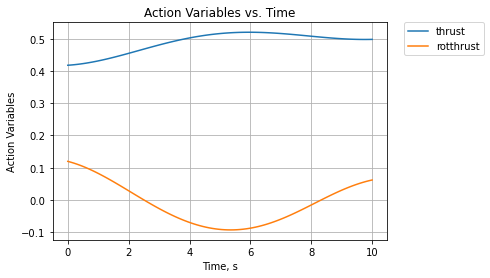

[70] loss: 0.813


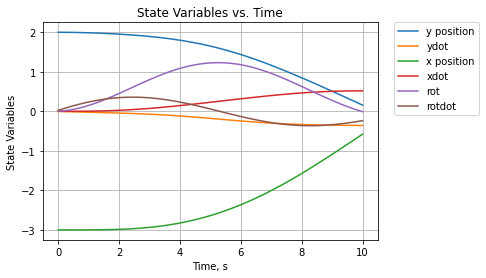

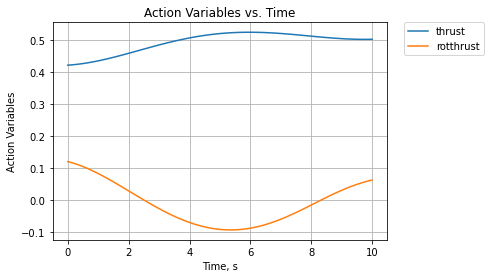

[71] loss: 0.800


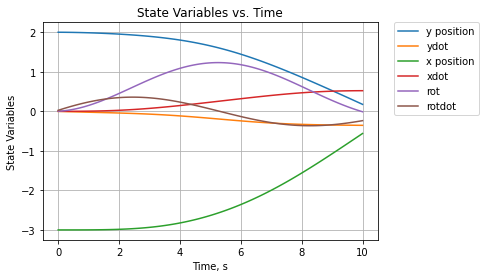

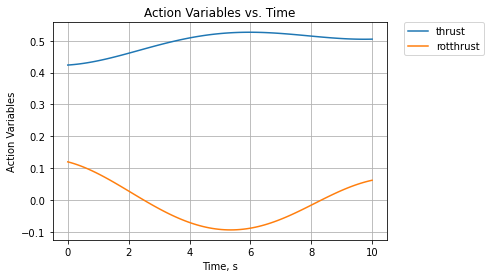

[72] loss: 0.788


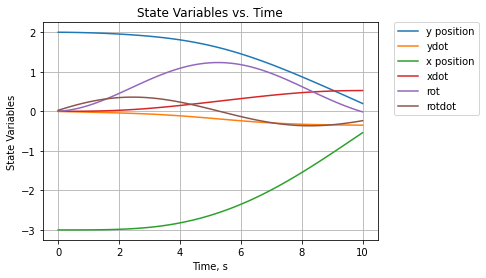

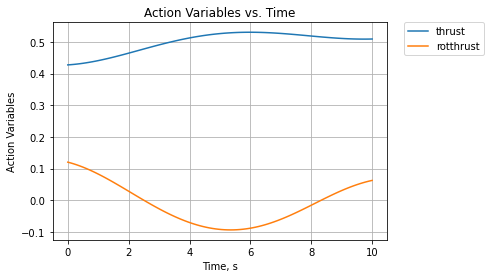

[73] loss: 0.777


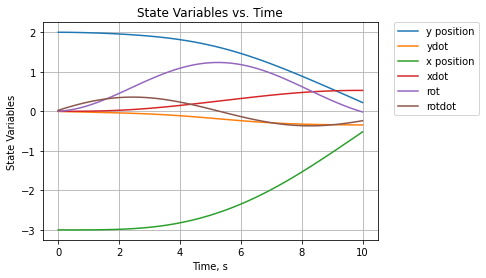

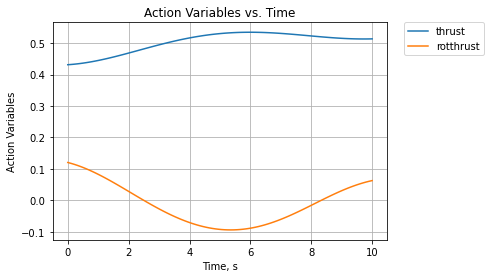

[74] loss: 0.768


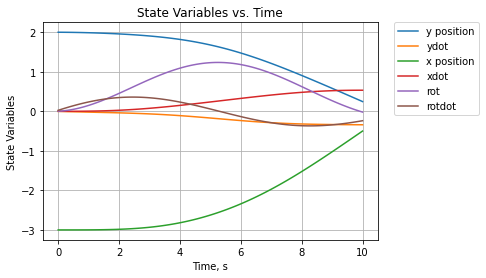

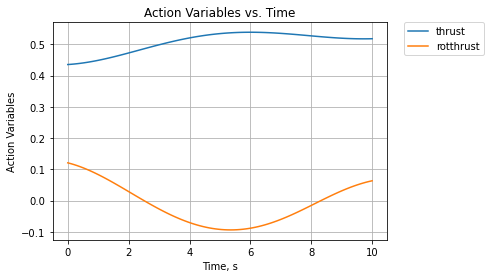

[75] loss: 0.761


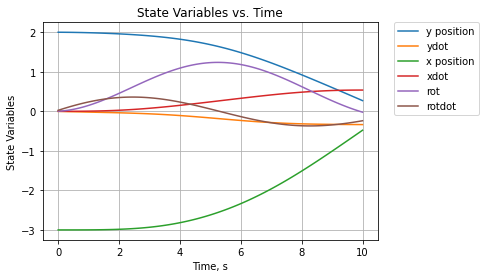

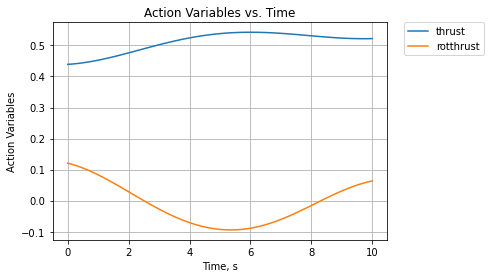

[76] loss: 0.757


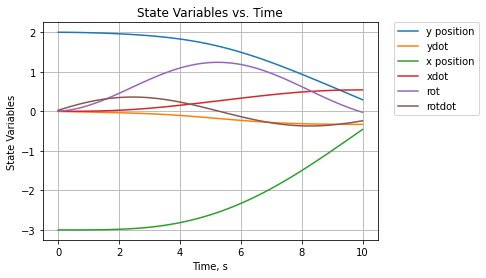

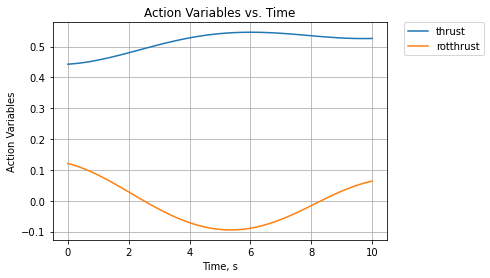

[77] loss: 0.755


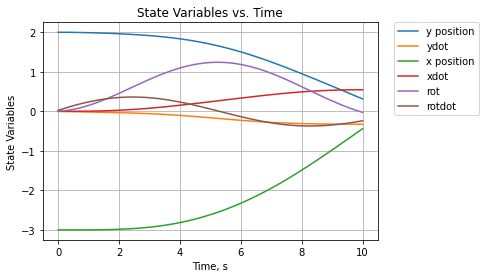

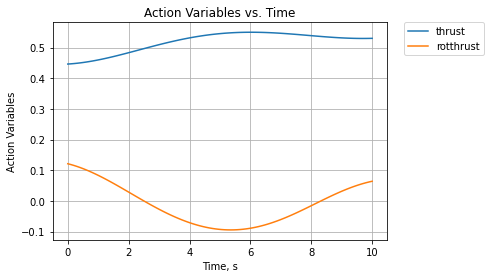

[78] loss: 0.754


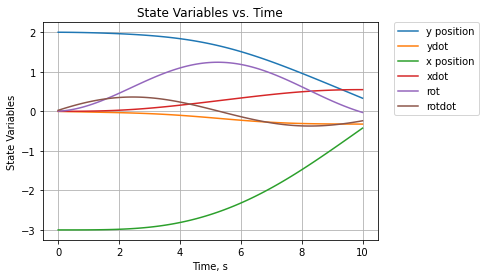

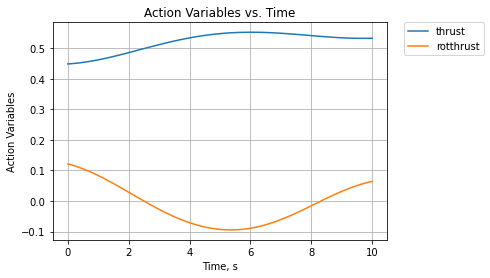

[79] loss: 0.754


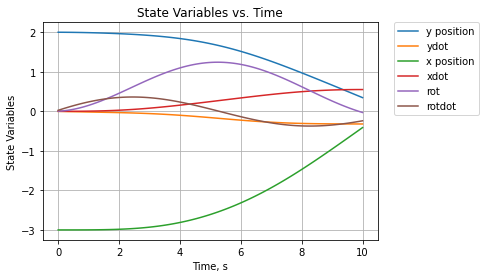

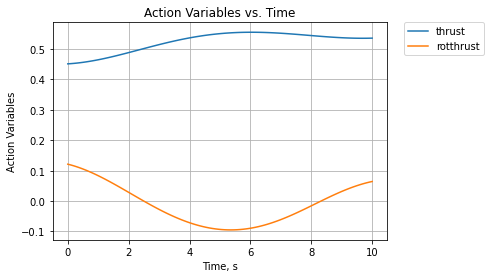

[80] loss: 0.754


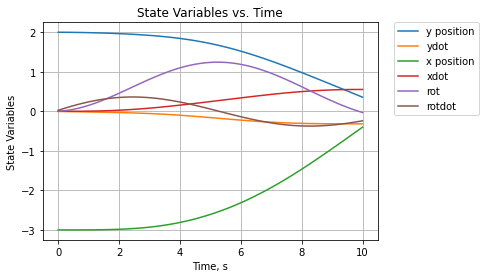

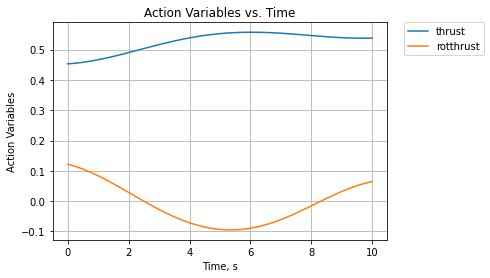

In [10]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 30  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, [-3, 0., 2., 0., 0., 0.])  # define simulation
o = Optimize(s)  # define optimizer
o.train(80)  # solve the optimization problem